OASIS_OAS1_0327_MR1_mri_talairach_orig.npz


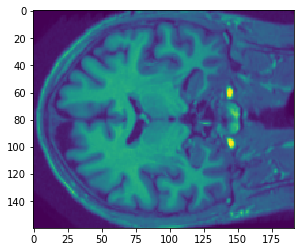

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
ar = '/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32'
train_dir = os.path.join(ar, 'train', 'origs')
for f in os.listdir(train_dir):
    
    if 'OASIS_OAS1_0327_MR1_mri_talairach_orig' in f:
        print(f)
        data = np.load(os.path.join(train_dir,f))
        plt.imshow(data['vol_data'][:, :, 112])

In [1]:
%load_ext autoreload
%autoreload 2

from dataset_utils import adni_loader
import json
import os
import sys

import tensorflow as tf
print(tf.__version__)
import keras.backend as K
gpu_ids = [3]
# set gpu id and tf settings
# os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(g) for g in gpu_ids])
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.tensorflow_backend.set_session(tf.Session(config=config))

import vte_runner
data_params = vte_runner.named_vte_data_params['adni-3d-100-unnorm-masked']

data_params['scale'] = 1  # always load full-scale data for evaluation
#data_params['n_unlabeled'] = 1  # just load one for training, we only want the validation set
#data_params['load_vols'] = False
ds = adni_loader.ADNIDataset(data_params)
_ = ds.load_dataset(debug=False)
vol_shape = (160, 192, 224, 1)



Using TensorFlow backend.
/afs/csail.mit.edu/u/x/xamyzhao/.conda/envs/cuda8/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')
../cnn_utils/vis_utils.py:14: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  mpl.use('Agg')


1.4.1
Loading adni dataset adni-unnorm-masked_100ul_atlas-l
Params: {'dataset_name': 'adni', 'source_name': 'atl', 'target_name': 'subjs', 'masked': True, 'n_shot': 1, 'use_atlas_as_source': True, 'img_shape': (160, 192, 224, 1), 'pred_img_shape': (160, 192, 1), 'aug_img_shape': (160, 192, 224, 1), 'n_unlabeled': 100, 'n_validation': 50, 'load_vols': True, 'aug_in_gen': True, 'n_flow_aug': None, 'n_vte_aug': None, 'unnormalized': True, 'use_labels': [0, 16, 10, 49, 8, 47, 4, 43, 7, 46, 12, 51, 2, 41, 28, 60, 11, 50, 13, 52, 17, 53, 14, 15, 18, 54, 24, 3, 42, 31, 63], 'final_test': False, 'n_dims': 3, 'scale': 1.0, 'orig_img_shape': (160, 192, 224, 1), 'split_id': None}
Got list of 7329 files from /data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/*.npz:
ADNI_ADNI-3T-FS-5.3-Long_293689.long.016_S_4591_base_mri_talairach_orig.npz
ADNI_ADNI-3T-FS-5.3-Long_78841.long.016_S_1326_base_mri_talairach_orig.npz
ADNI_ADNI-1.5T-FS-5.3-Long_436815.long.094_S_1330_base_mri_talaira

In [2]:
import numpy as np
import medipy_metrics
import classification_utils
import IPython
import PIL
import vte_runner
import vis_utils

import medipy_metrics

label_mapping = vte_runner.voxelmorph_labels
# load each subject, then evaluate each slice
n_test_examples = len(ds.files_labeled_valid)
n_test_examples = 100
dice_per_label = np.zeros((len(label_mapping,)))

source_X = ds.X_atlas
source_Y = ds.Y_atlas

dices = []
for bi in range(len(ds.files_unlabeled_train)):#[3, 36, 59, 96, 30]:
    print('Showing unlabeled subject {} of {}'.format(bi, n_test_examples))
    vol_file = ds.files_unlabeled_train[bi]
    
    target_X, target_Y =  adni_loader._load_vol_and_seg(vol_file, 
                                                        mask_vol = ds.params['masked'],
                                                        scale=data_params['scale'] )

    # only compute dice on the labels that we care about
    dice = medipy_metrics.dice(source_Y, target_Y[np.newaxis], labels=ds.label_mapping[1:])
    
    dices.append(np.mean(dice))





Showing unlabeled subject 0 of 100
Showing unlabeled subject 1 of 100
Showing unlabeled subject 2 of 100
Showing unlabeled subject 3 of 100
Showing unlabeled subject 4 of 100
Showing unlabeled subject 5 of 100
Showing unlabeled subject 6 of 100
Showing unlabeled subject 7 of 100
Showing unlabeled subject 8 of 100
Showing unlabeled subject 9 of 100
Showing unlabeled subject 10 of 100
Showing unlabeled subject 11 of 100
Showing unlabeled subject 12 of 100
Showing unlabeled subject 13 of 100
Showing unlabeled subject 14 of 100
Showing unlabeled subject 15 of 100
Showing unlabeled subject 16 of 100
Showing unlabeled subject 17 of 100
Showing unlabeled subject 18 of 100
Showing unlabeled subject 19 of 100
Showing unlabeled subject 20 of 100
Showing unlabeled subject 21 of 100
Showing unlabeled subject 22 of 100
Showing unlabeled subject 23 of 100
Showing unlabeled subject 24 of 100
Showing unlabeled subject 25 of 100
Showing unlabeled subject 26 of 100
Showing unlabeled subject 27 of 100
Sh

In [6]:
print(len(dices))
idxs = np.linspace(0, len(dices), len(dices), endpoint=False, dtype=int).tolist()

sorted_dice, best_idxs = zip(*sorted(zip(dices, idxs), reverse=True))
print(sorted_dice)
print(best_idxs)
print(len(sorted_dice))

idx = [i for i in idxs if '50435' in ds.files_unlabeled_train[i]][0]
print(ds.files_unlabeled_train[idx])
print(dices[idx])

101
(0.66264313, 0.6597445, 0.64766514, 0.6456301, 0.6399817, 0.6376244, 0.6346403, 0.63462573, 0.63115686, 0.62927526, 0.62870413, 0.62817186, 0.62802976, 0.6218116, 0.619438, 0.618775, 0.6181578, 0.6170769, 0.61657184, 0.61563814, 0.6148998, 0.6145387, 0.6131434, 0.6128728, 0.61117303, 0.6043348, 0.6031794, 0.6024403, 0.6019449, 0.60098267, 0.6008344, 0.60079044, 0.6005612, 0.59865284, 0.5979513, 0.5960862, 0.5953926, 0.5933393, 0.59126973, 0.59017545, 0.5899153, 0.5878683, 0.5867748, 0.5866353, 0.5866001, 0.5851405, 0.58343136, 0.58153623, 0.5800194, 0.57776165, 0.5774578, 0.5755175, 0.5752558, 0.5741462, 0.5730934, 0.5721072, 0.5720329, 0.5710736, 0.56909007, 0.56747603, 0.5663554, 0.5653569, 0.565219, 0.56476533, 0.564764, 0.56445694, 0.5642196, 0.56406426, 0.56380045, 0.561512, 0.55984265, 0.55802894, 0.5546062, 0.5536305, 0.5533599, 0.5531889, 0.5473494, 0.5470744, 0.5456037, 0.5391706, 0.5391479, 0.53532994, 0.53302807, 0.53290796, 0.53177685, 0.53143007, 0.527752, 0.51775813, 

IndexError: list index out of range

Showing unlabeled subject 0 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_090914_WJ88NK_FS_mri_talairach_orig.npz
0.66264313


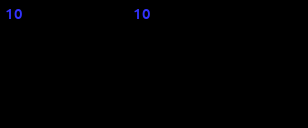

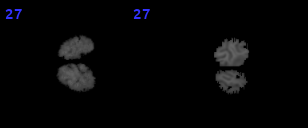

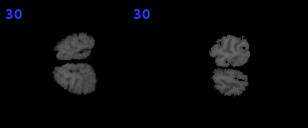

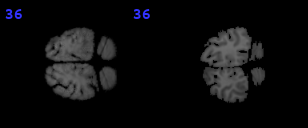

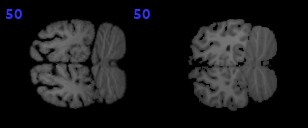

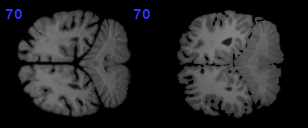

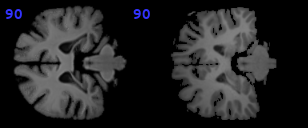

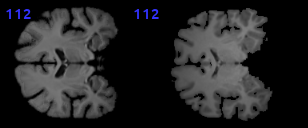

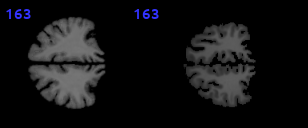

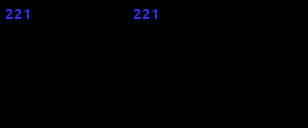

Showing unlabeled subject 1 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_79126.long.002_S_1261_base_mri_talairach_orig.npz
0.6597445


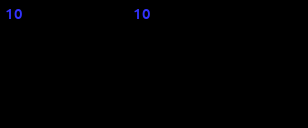

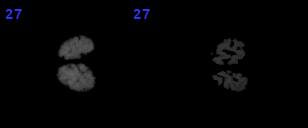

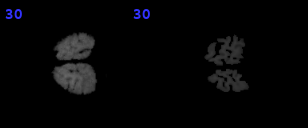

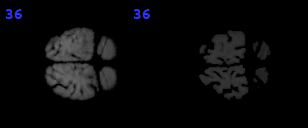

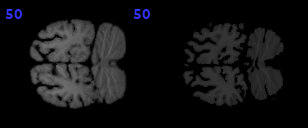

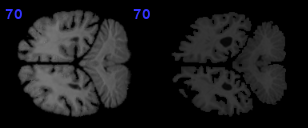

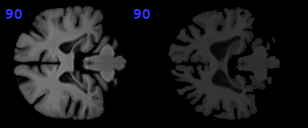

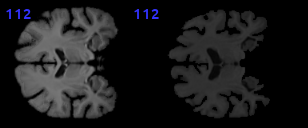

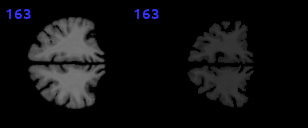

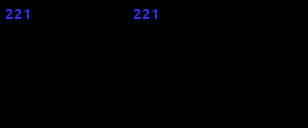

Showing unlabeled subject 2 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_090709_WE83EH_FS_mri_talairach_orig.npz
0.64766514


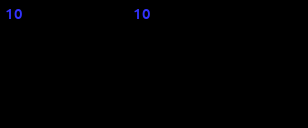

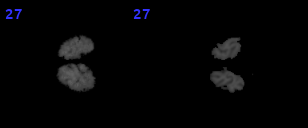

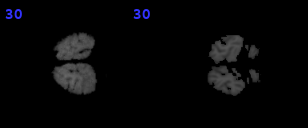

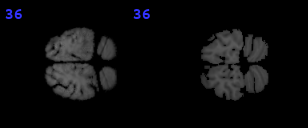

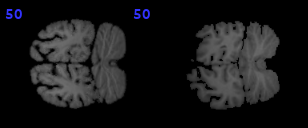

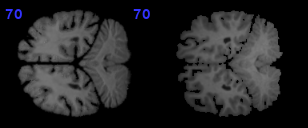

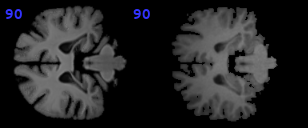

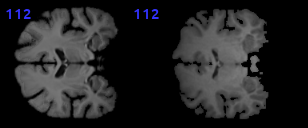

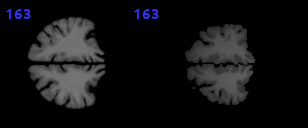

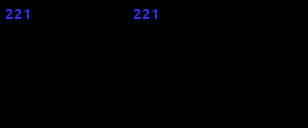

Showing unlabeled subject 3 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100121_GF37CB_FS_mri_talairach_orig.npz
0.6456301


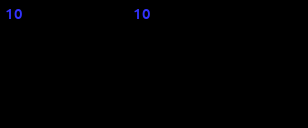

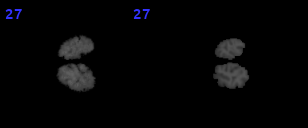

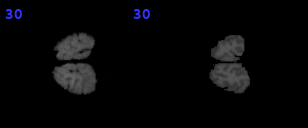

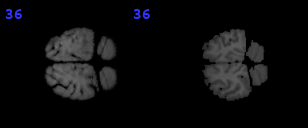

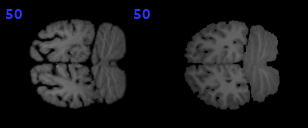

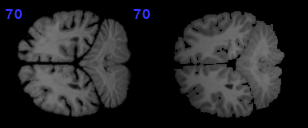

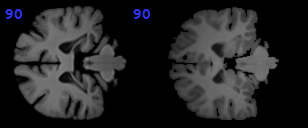

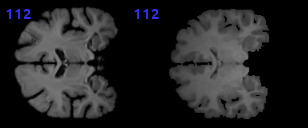

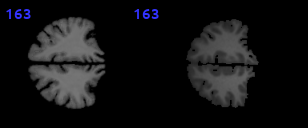

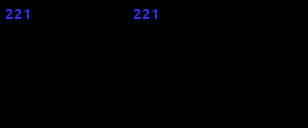

Showing unlabeled subject 4 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/OASIS_OAS1_0327_MR1_mri_talairach_orig.npz
0.6399817


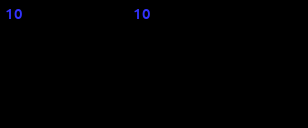

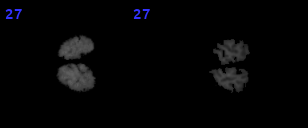

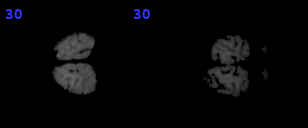

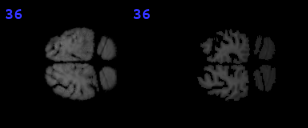

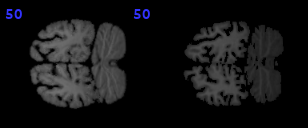

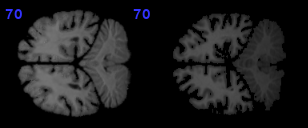

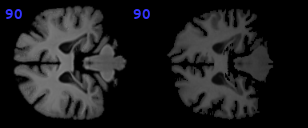

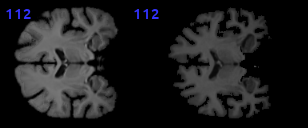

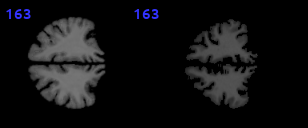

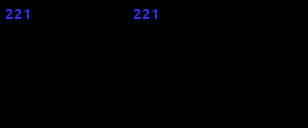

Showing unlabeled subject 5 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100308_CQ45RU_FS_mri_talairach_orig.npz
0.6376244


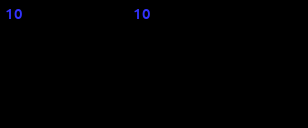

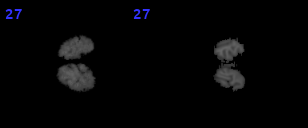

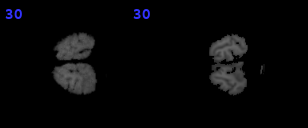

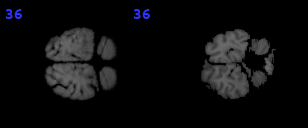

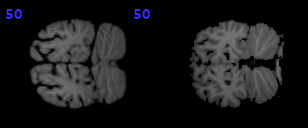

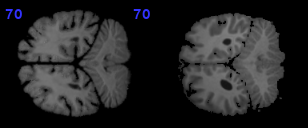

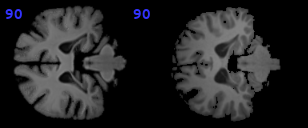

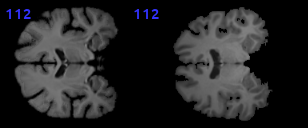

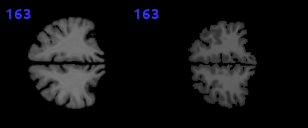

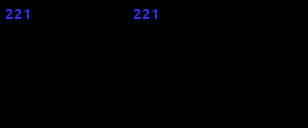

Showing unlabeled subject 6 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_398370.long.126_S_2405_base_mri_talairach_orig.npz
0.6346403


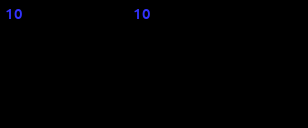

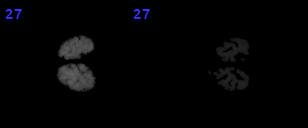

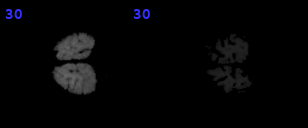

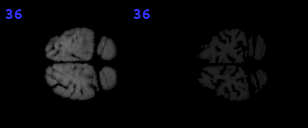

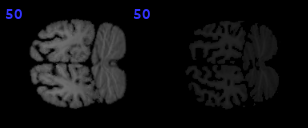

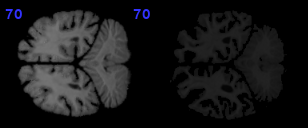

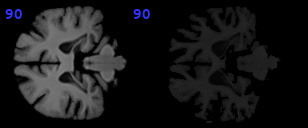

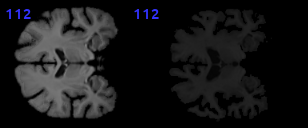

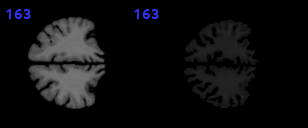

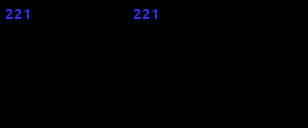

Showing unlabeled subject 7 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_96119.long.033_S_0723_base_mri_talairach_orig.npz
0.63462573


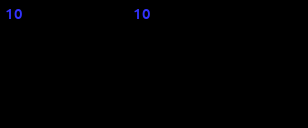

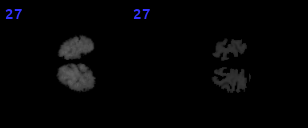

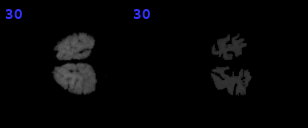

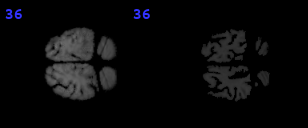

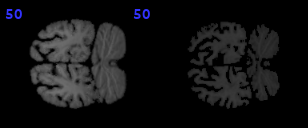

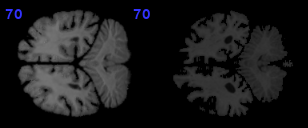

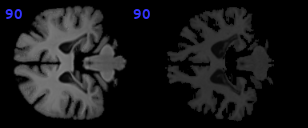

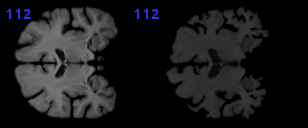

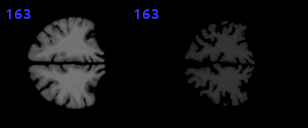

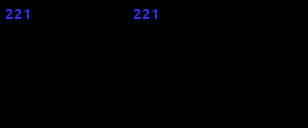

Showing unlabeled subject 8 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/MCIC_Site_A_A00036298_mri_talairach_orig.npz
0.63115686


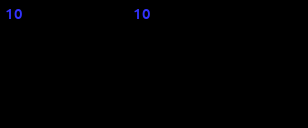

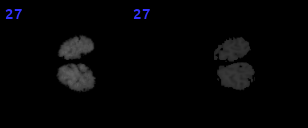

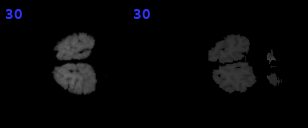

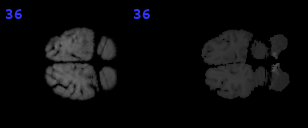

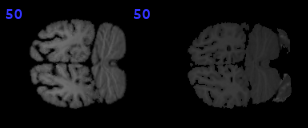

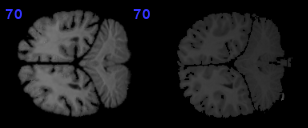

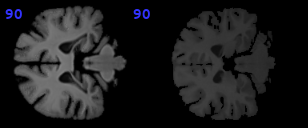

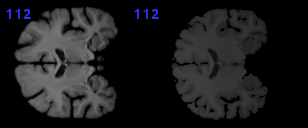

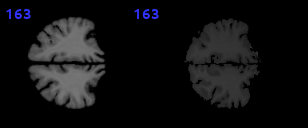

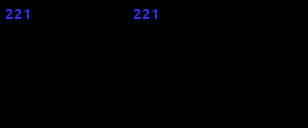

Showing unlabeled subject 9 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_277027.long.153_S_2148_base_mri_talairach_orig.npz
0.62927526


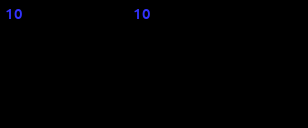

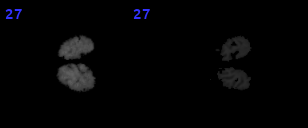

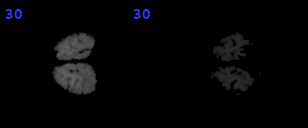

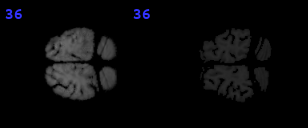

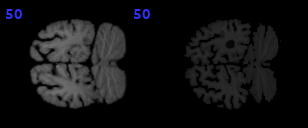

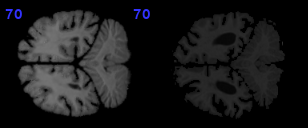

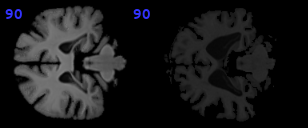

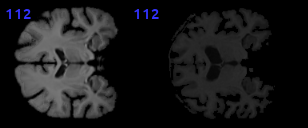

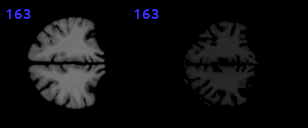

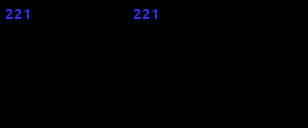

Showing unlabeled subject 10 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_394756.long.011_S_4235_base_mri_talairach_orig.npz
0.62870413


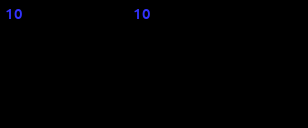

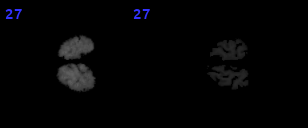

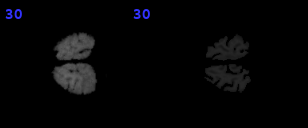

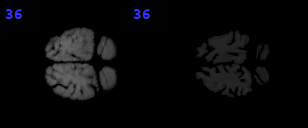

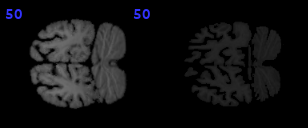

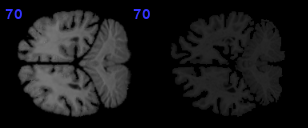

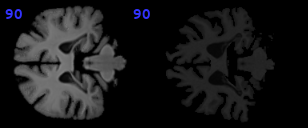

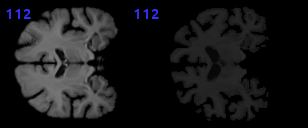

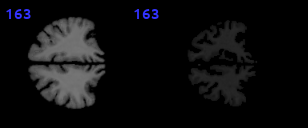

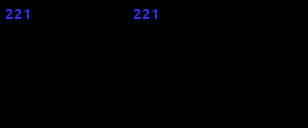

Showing unlabeled subject 11 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_110314_JD99RH_FS_mri_talairach_orig.npz
0.62817186


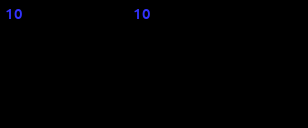

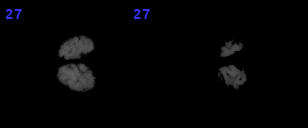

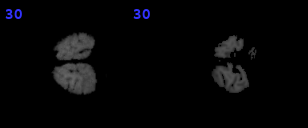

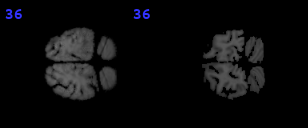

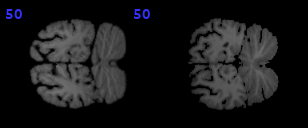

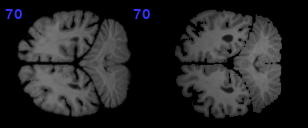

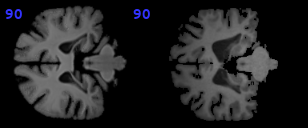

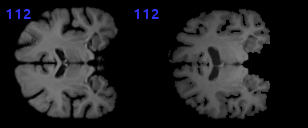

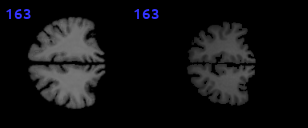

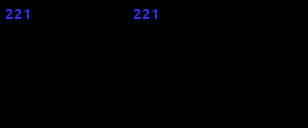

Showing unlabeled subject 12 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_163740.long.136_S_0429_base_mri_talairach_orig.npz
0.62802976


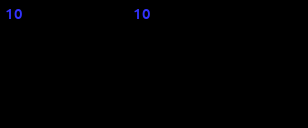

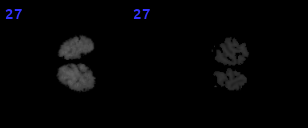

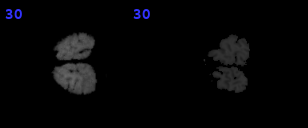

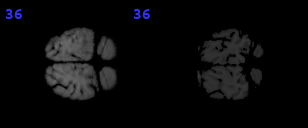

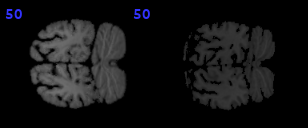

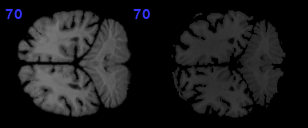

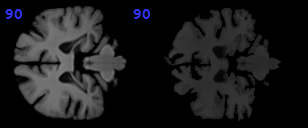

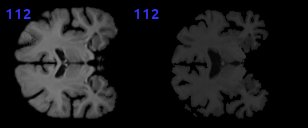

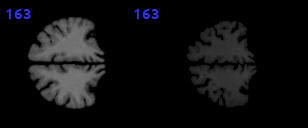

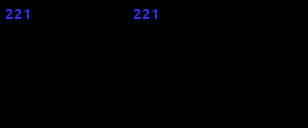

Showing unlabeled subject 13 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_090923_PH66XU_FS_mri_talairach_orig.npz
0.6218116


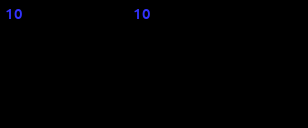

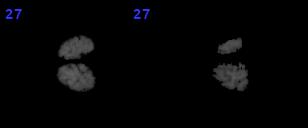

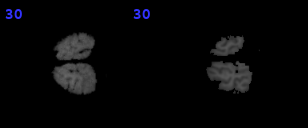

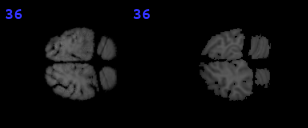

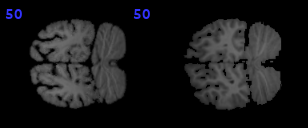

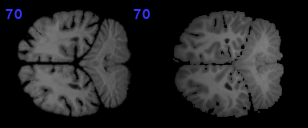

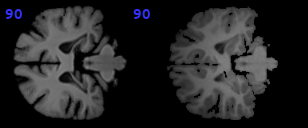

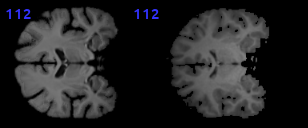

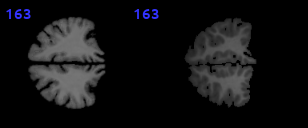

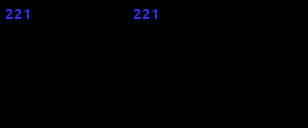

Showing unlabeled subject 14 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_66051.long.094_S_1188_base_mri_talairach_orig.npz
0.619438


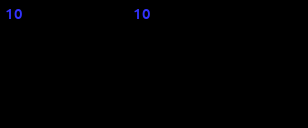

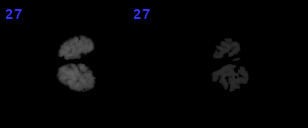

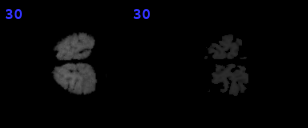

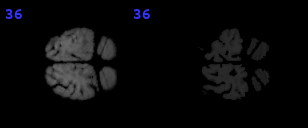

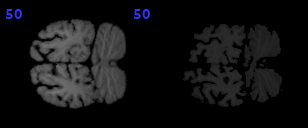

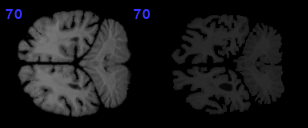

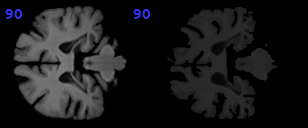

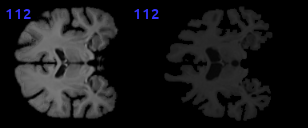

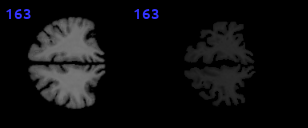

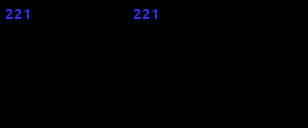

Showing unlabeled subject 15 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_424046.long.073_S_2225_base_mri_talairach_orig.npz
0.618775


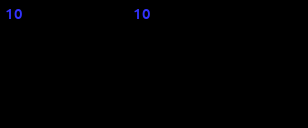

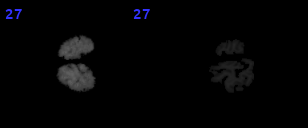

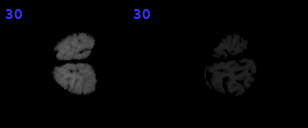

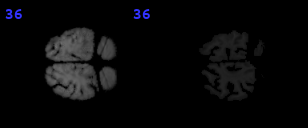

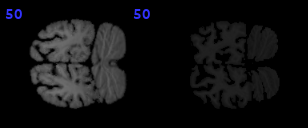

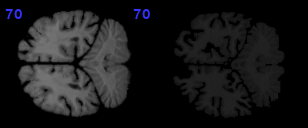

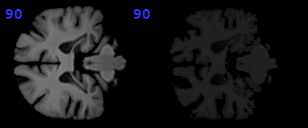

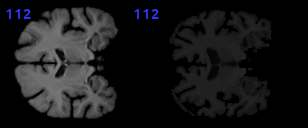

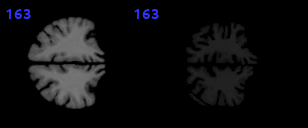

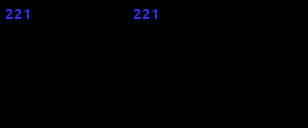

Showing unlabeled subject 16 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_091222_EV77WH_FS_mri_talairach_orig.npz
0.6181578


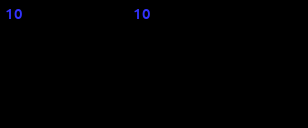

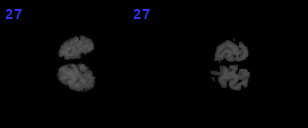

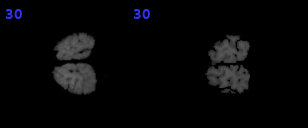

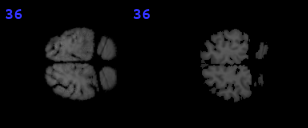

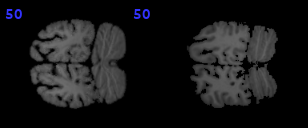

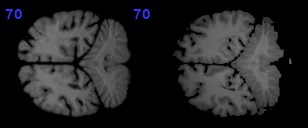

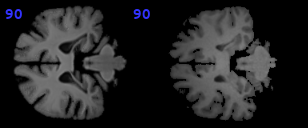

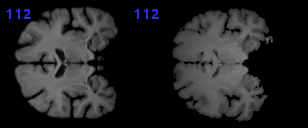

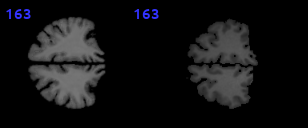

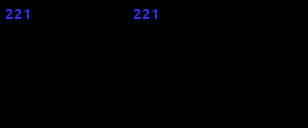

Showing unlabeled subject 17 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100627_BA34XH_FS_mri_talairach_orig.npz
0.6170769


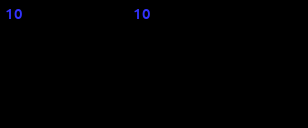

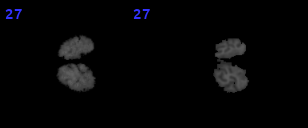

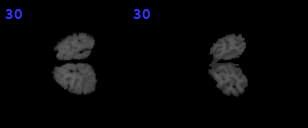

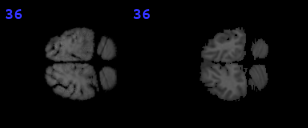

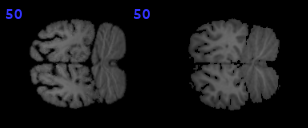

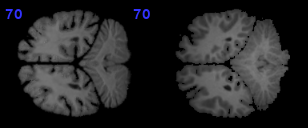

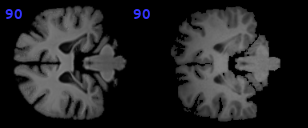

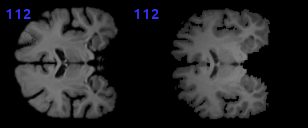

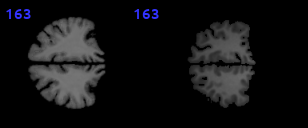

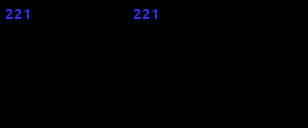

Showing unlabeled subject 18 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADHD200_Peking_2123983_mri_talairach_orig.npz
0.61657184


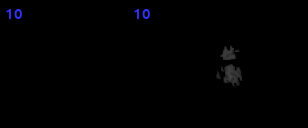

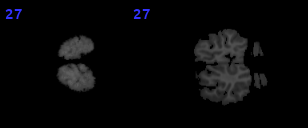

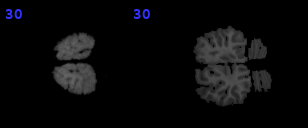

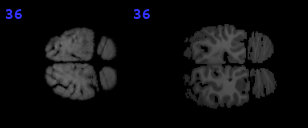

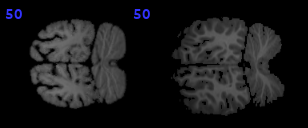

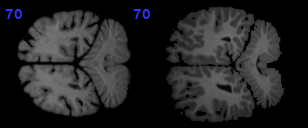

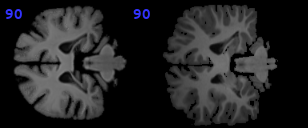

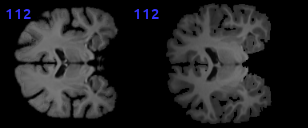

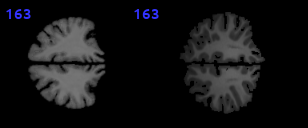

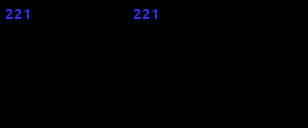

Showing unlabeled subject 19 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_100526_TE48VB_FS_mri_talairach_orig.npz
0.61563814


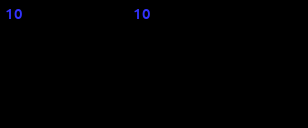

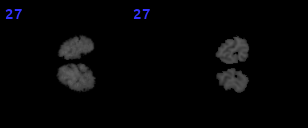

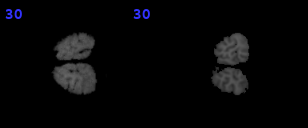

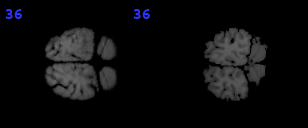

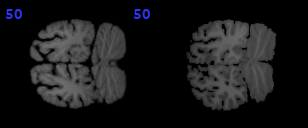

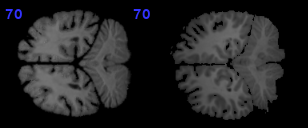

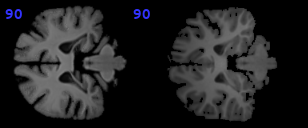

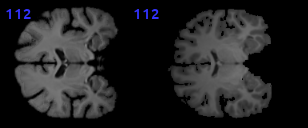

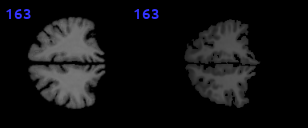

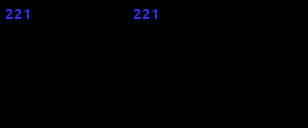

Showing unlabeled subject 0 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_090914_WJ88NK_FS_mri_talairach_orig.npz
0.66264313


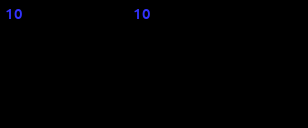

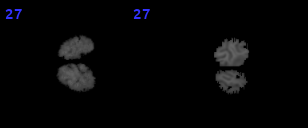

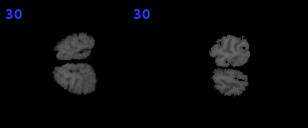

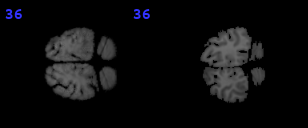

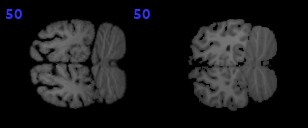

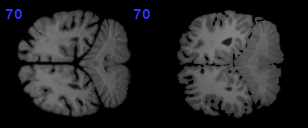

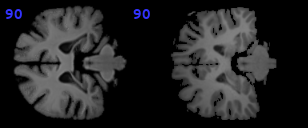

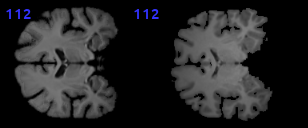

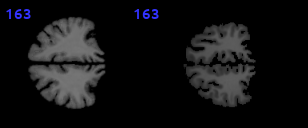

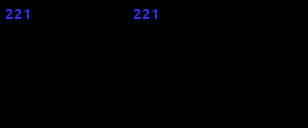

Showing unlabeled subject 1 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADHD200_NYU_10068_mri_talairach_orig.npz
0.6597445


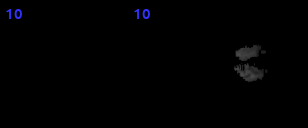

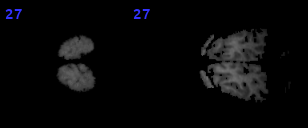

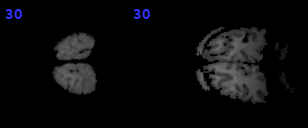

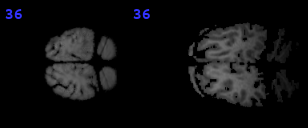

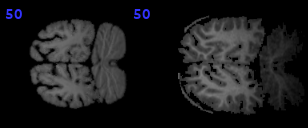

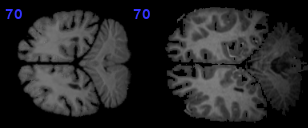

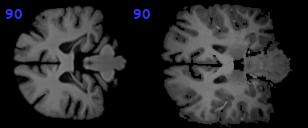

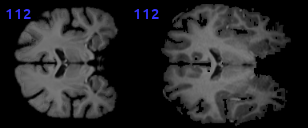

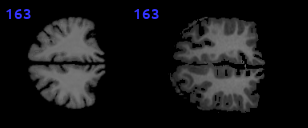

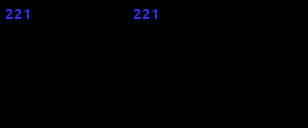

Showing unlabeled subject 2 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADHD200_NYU_10120_mri_talairach_orig.npz
0.64766514


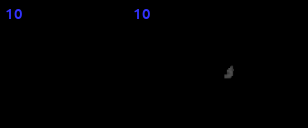

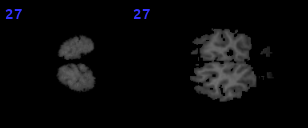

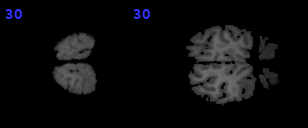

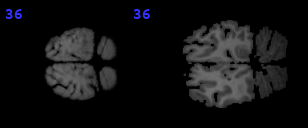

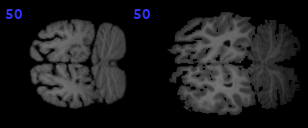

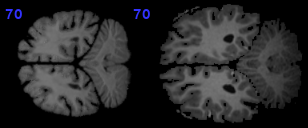

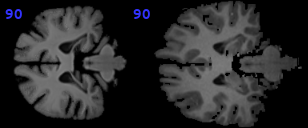

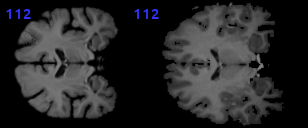

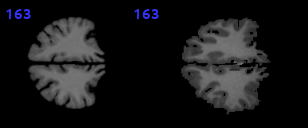

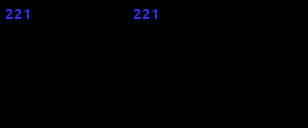

Showing unlabeled subject 3 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_217623.long.023_S_0625_base_mri_talairach_orig.npz
0.6456301


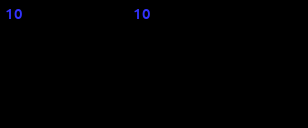

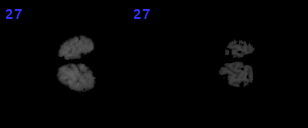

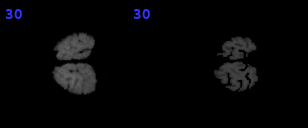

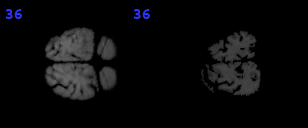

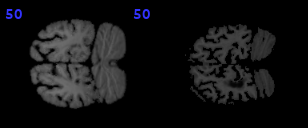

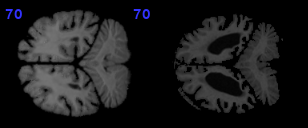

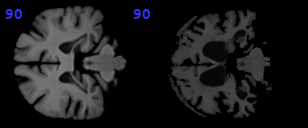

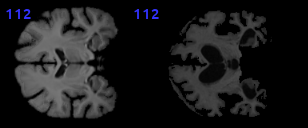

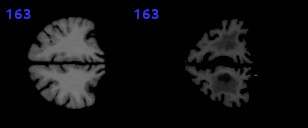

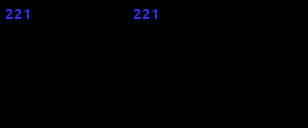

Showing unlabeled subject 4 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ABIDE_50558_mri_talairach_orig.npz
0.6399817


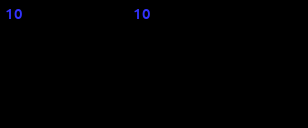

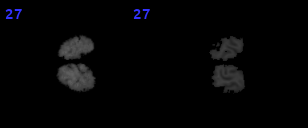

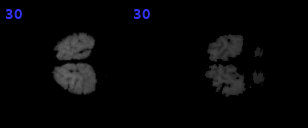

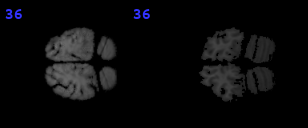

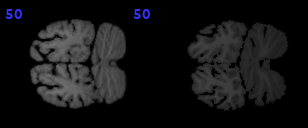

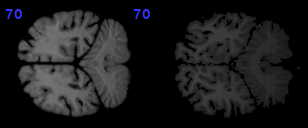

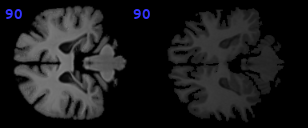

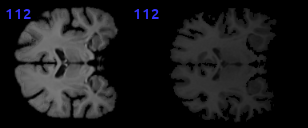

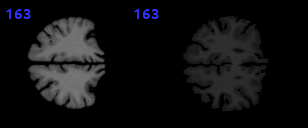

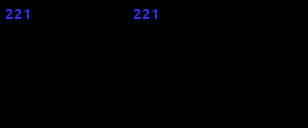

Showing unlabeled subject 5 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_349295.long.021_S_2142_base_mri_talairach_orig.npz
0.6376244


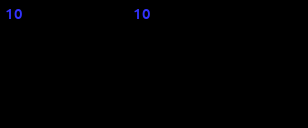

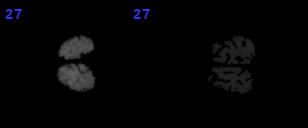

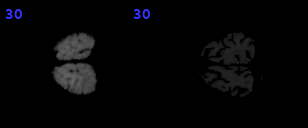

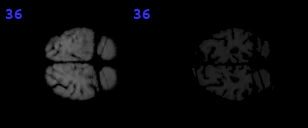

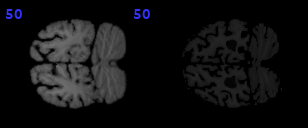

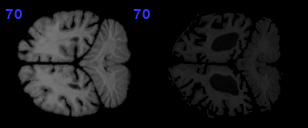

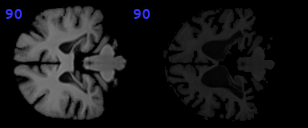

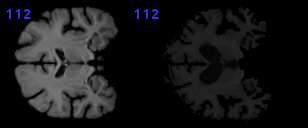

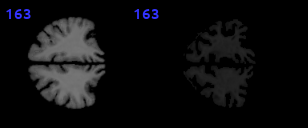

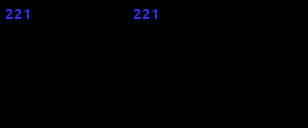

Showing unlabeled subject 6 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_64609.long.016_S_0702_base_mri_talairach_orig.npz
0.6346403


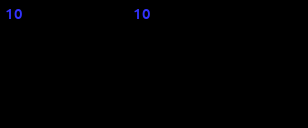

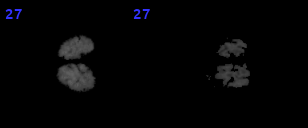

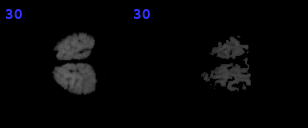

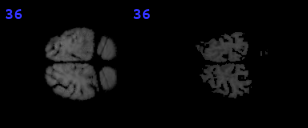

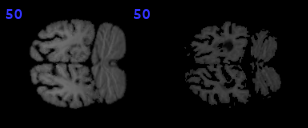

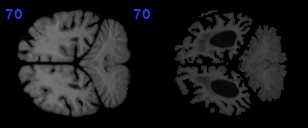

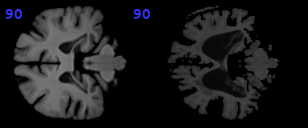

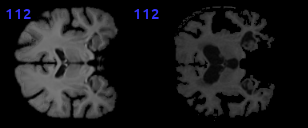

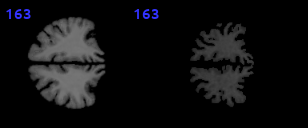

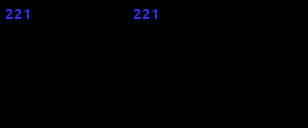

Showing unlabeled subject 7 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/PPMI_3650_mri_talairach_orig.npz
0.63462573


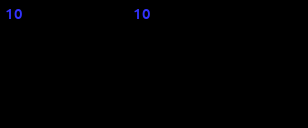

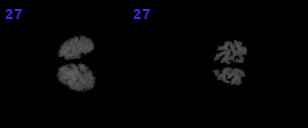

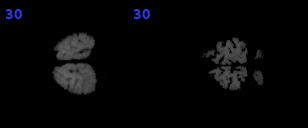

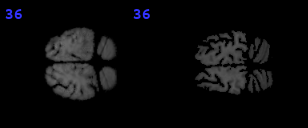

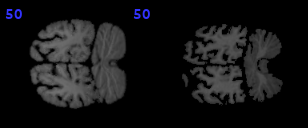

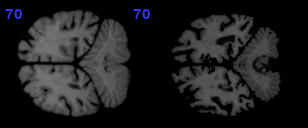

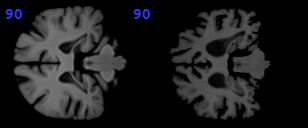

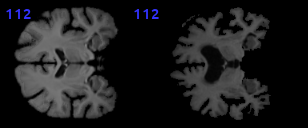

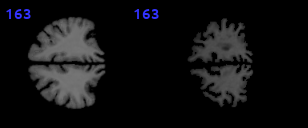

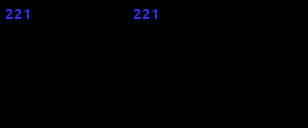

Showing unlabeled subject 8 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_65343.long.027_S_0850_base_mri_talairach_orig.npz
0.63115686


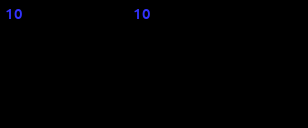

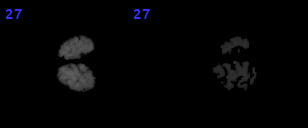

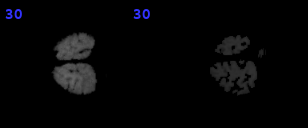

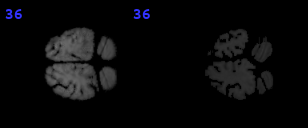

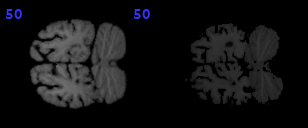

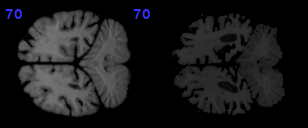

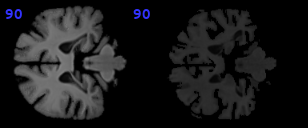

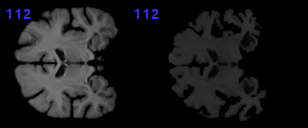

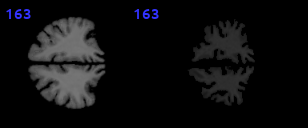

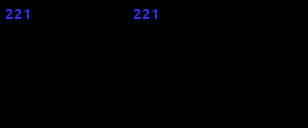

Showing unlabeled subject 9 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_294850.long.027_S_0408_base_mri_talairach_orig.npz
0.62927526


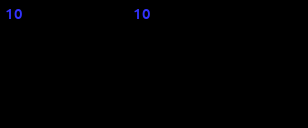

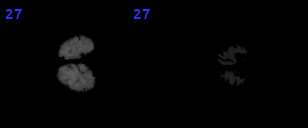

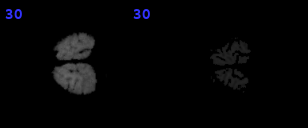

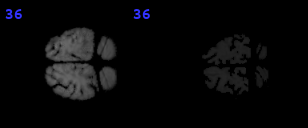

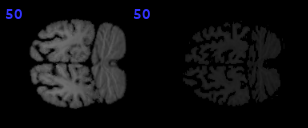

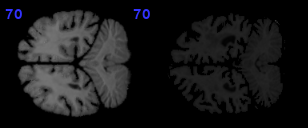

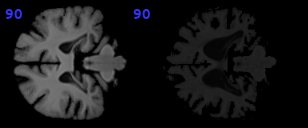

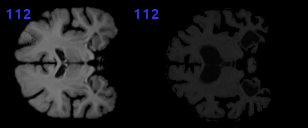

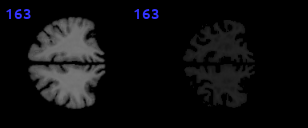

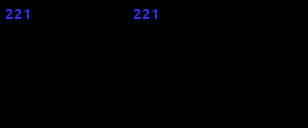

Showing unlabeled subject 10 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_377050.long.036_S_4736_base_mri_talairach_orig.npz
0.62870413


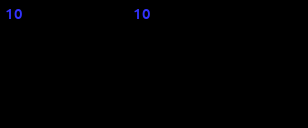

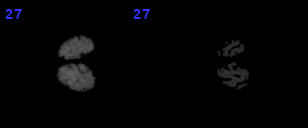

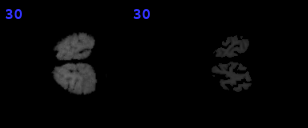

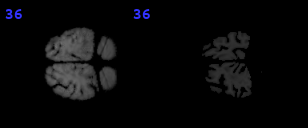

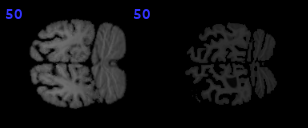

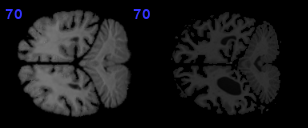

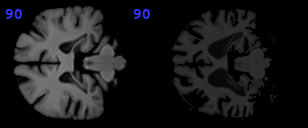

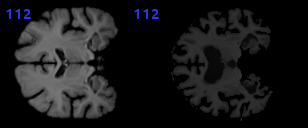

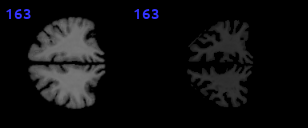

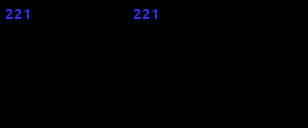

Showing unlabeled subject 11 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_451346.long.009_S_0751_base_mri_talairach_orig.npz
0.62817186


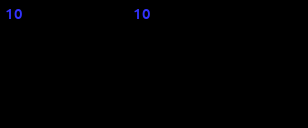

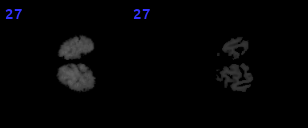

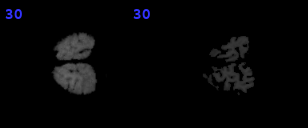

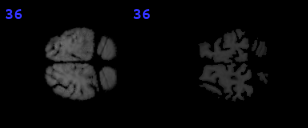

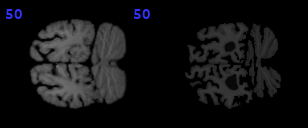

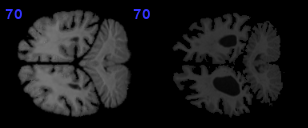

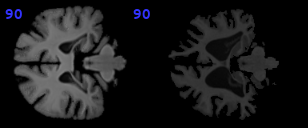

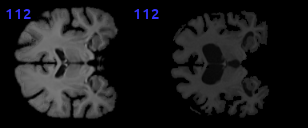

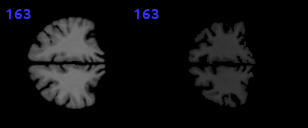

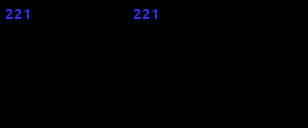

Showing unlabeled subject 12 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_120621_KM56MK_FS_mri_talairach_orig.npz
0.62802976


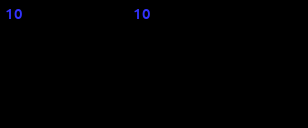

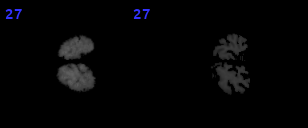

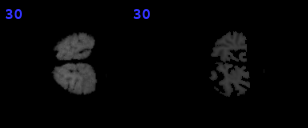

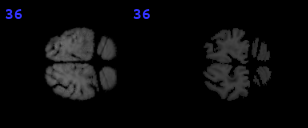

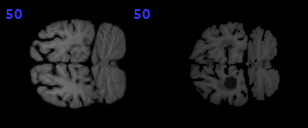

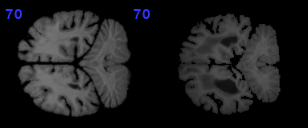

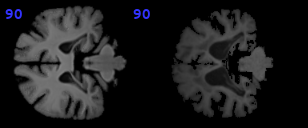

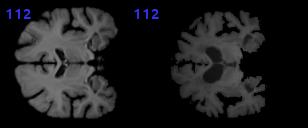

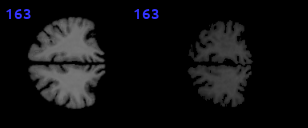

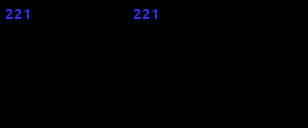

Showing unlabeled subject 13 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_119656.long.133_S_1170_base_mri_talairach_orig.npz
0.6218116


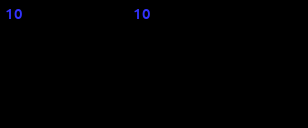

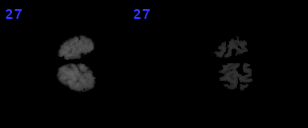

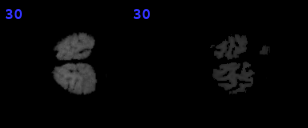

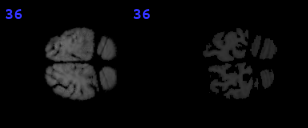

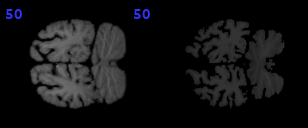

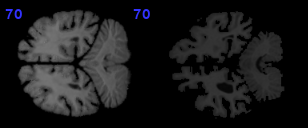

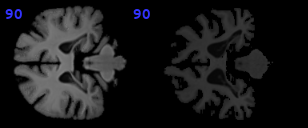

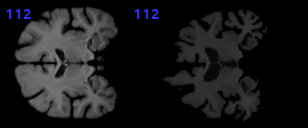

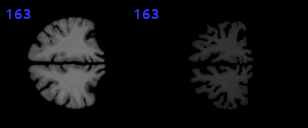

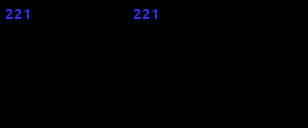

Showing unlabeled subject 14 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_313580.long.006_S_4546_base_mri_talairach_orig.npz
0.619438


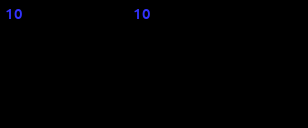

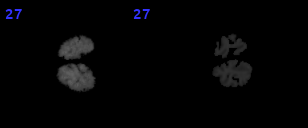

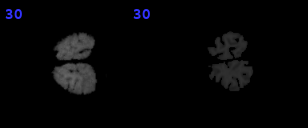

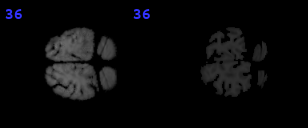

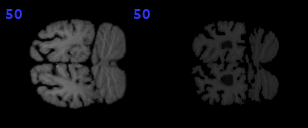

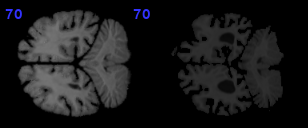

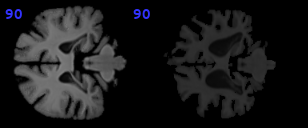

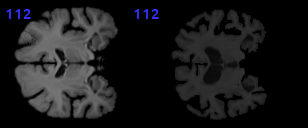

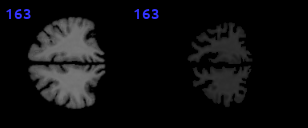

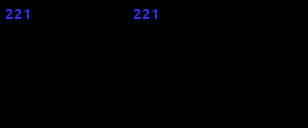

Showing unlabeled subject 15 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_85547.long.002_S_0955_base_mri_talairach_orig.npz
0.618775


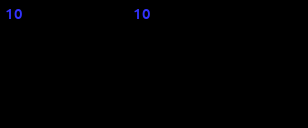

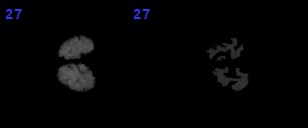

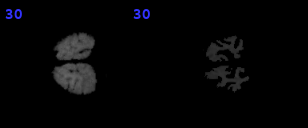

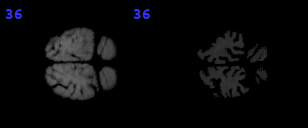

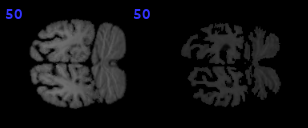

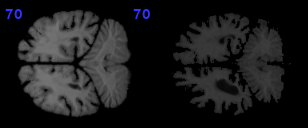

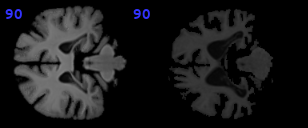

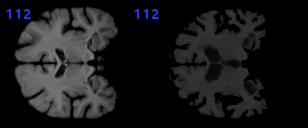

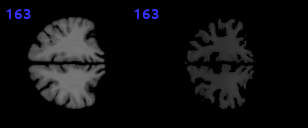

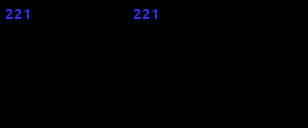

Showing unlabeled subject 16 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-1.5T-FS-5.3-Long_121812.long.029_S_1218_base_mri_talairach_orig.npz
0.6181578


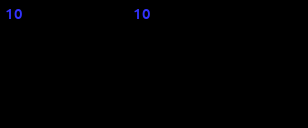

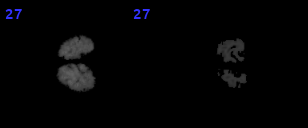

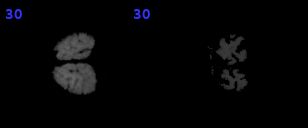

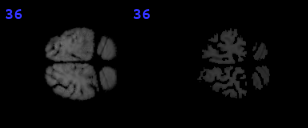

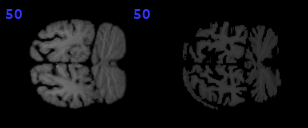

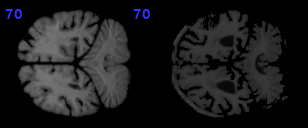

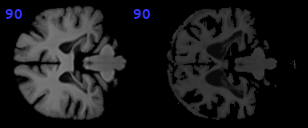

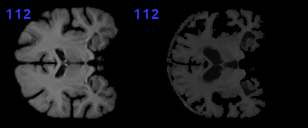

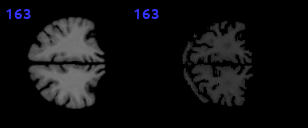

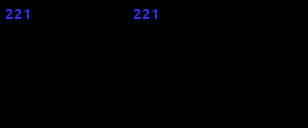

Showing unlabeled subject 17 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ADNI_ADNI-3T-FS-5.3-Long_357718.long.130_S_4641_base_mri_talairach_orig.npz
0.6170769


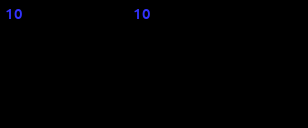

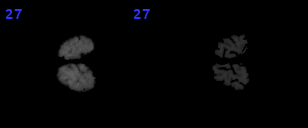

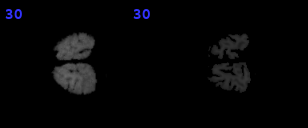

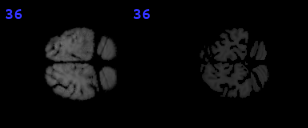

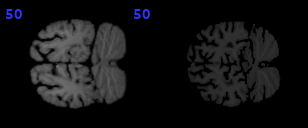

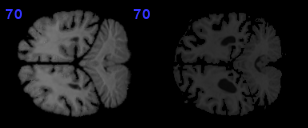

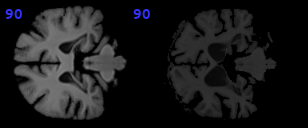

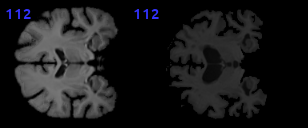

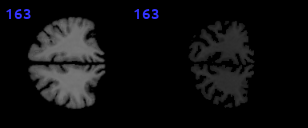

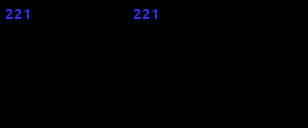

Showing unlabeled subject 18 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/GSP_120628_DZ38NB_FS_mri_talairach_orig.npz
0.61657184


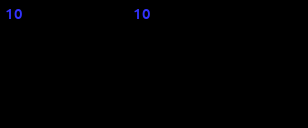

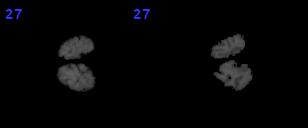

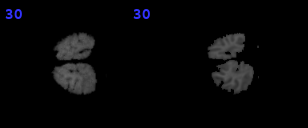

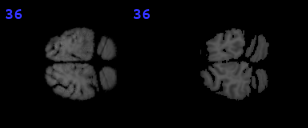

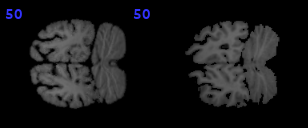

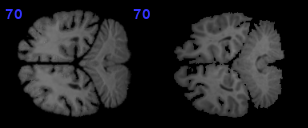

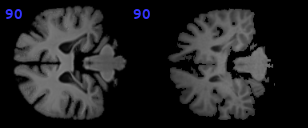

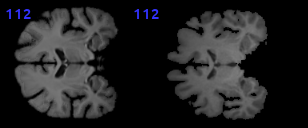

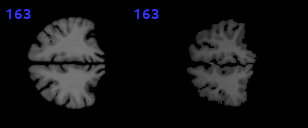

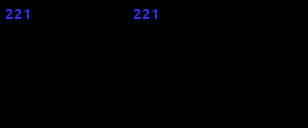

Showing unlabeled subject 19 of 100
/data/ddmg/voxelmorph/data/t1_mix/proc/resize256-crop_x32/train/origs/ABIDE_50351_mri_talairach_orig.npz
0.61563814


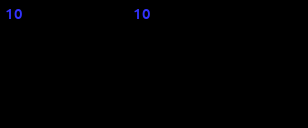

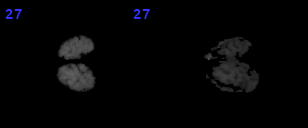

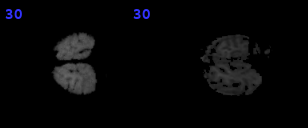

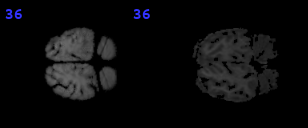

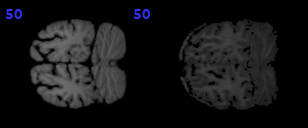

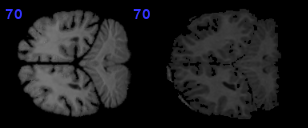

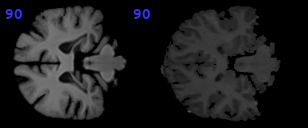

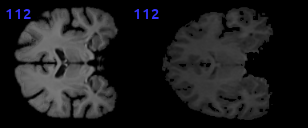

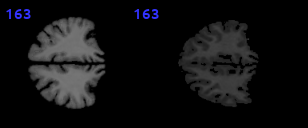

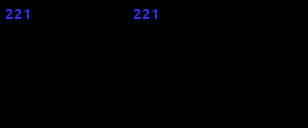

In [5]:
n_top = 20

for bi in range(n_top):#[3, 36, 59, 96, 30]:
    vol_file = ds.files_unlabeled_train[best_idxs[bi]]
    
    target_X, target_Y =  adni_loader._load_vol_and_seg(vol_file, 
                                                        mask_vol = ds.params['masked'],
                                                        scale=data_params['scale'] )

    print('Showing unlabeled subject {} of {}'.format(bi, n_test_examples))
    n_slices = target_X.shape[2]
    print(vol_file)
    print(sorted_dice[bi])
    #slice_idx = np.random.choice(source_X.shape[-2], 1)[0]
    for slice_idx in sorted([36, 221, 27, 163, 10, 30, 50, 70, 90, 112]):
        
        IPython.display.display(PIL.Image.fromarray(
            vis_utils.label_ims(
                np.concatenate([source_X[:, :, :, slice_idx] , 
                                target_X[np.newaxis, :, :, slice_idx]], axis=0),
                slice_idx,
                concat_axis=1
            )
        ))
    
# show the worst, just for reference
for bi in range(n_top):#[3, 36, 59, 96, 30]:
    vol_file = ds.files_unlabeled_train[best_idxs[-bi]]
    
    
    target_X, target_Y =  adni_loader._load_vol_and_seg(vol_file, 
                                                        mask_vol = ds.params['masked'],
                                                        scale=data_params['scale'] )
    
    print('Showing unlabeled subject {} of {}'.format(bi, n_test_examples))
    n_slices = target_X.shape[2]
    print(vol_file)
    print(sorted_dice[bi])
    #slice_idx = np.random.choice(source_X.shape[-2], 1)[0]
    for slice_idx in sorted([36, 221, 27, 163, 10, 30, 50, 70, 90, 112]):
        
        IPython.display.display(PIL.Image.fromarray(
            vis_utils.label_ims(
                np.concatenate([source_X[:, :, :, slice_idx] , 
                                target_X[np.newaxis, :, :, slice_idx]], axis=0),
                slice_idx,
                concat_axis=1
            )
        ))
    



